## Homework 12: Time Series Analysis
### Dua Batool

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore") #optional
plt.style.use('fivethirtyeight') #optional
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_csv('karachi-weather-2021-2023.csv' , parse_dates=['datetime'])
df.head()

,datetime,temp
0,2021-01-01,15.0
1,2021-01-02,15.4
2,2021-01-03,15.6
3,2021-01-04,16.3
4,2021-01-05,17.1


In [3]:
df.isnull().sum()

datetime    0
temp        0
dtype: int64

In [4]:
df1 = df.copy()

### Q1

In [5]:
df1 = df1.set_index('datetime')

In [6]:
df1.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26'],
              dtype='datetime64[ns]', name='datetime', length=846, freq=None)

In [7]:
df1.head()

,temp
datetime,
2021-01-01,15.0
2021-01-02,15.4
2021-01-03,15.6
2021-01-04,16.3
2021-01-05,17.1


In [9]:
week_data = df1['temp'].resample('W').mean()

In [10]:
week_data

datetime
2021-01-03    15.333333
2021-01-10    16.028571
2021-01-17    17.085714
2021-01-24    19.457143
2021-01-31    17.800000
                ...    
2023-04-02    26.414286
2023-04-09    27.328571
2023-04-16    27.628571
2023-04-23    29.414286
2023-04-30    29.700000
Freq: W-SUN, Name: temp, Length: 122, dtype: float64

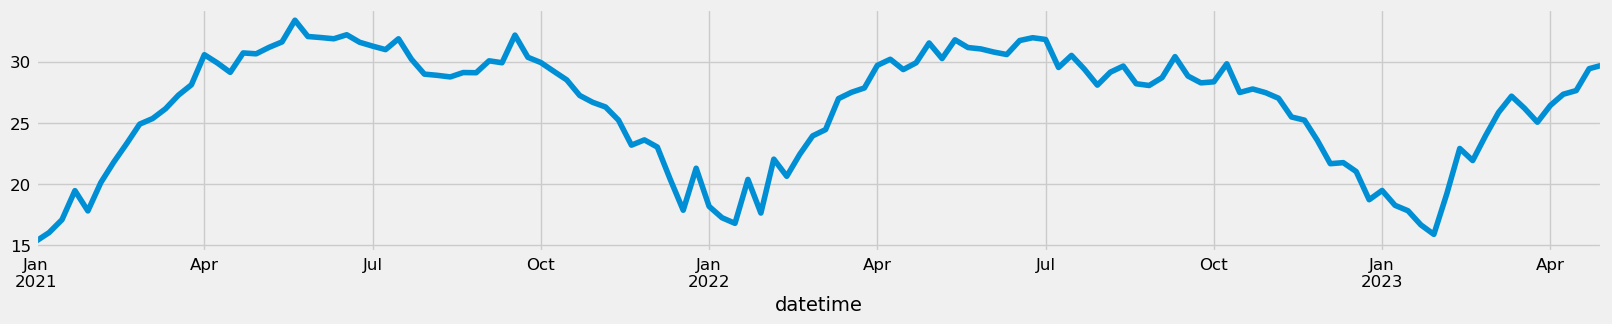

In [11]:
week_data.plot(figsize=(18, 3))
plt.show()

### Q2

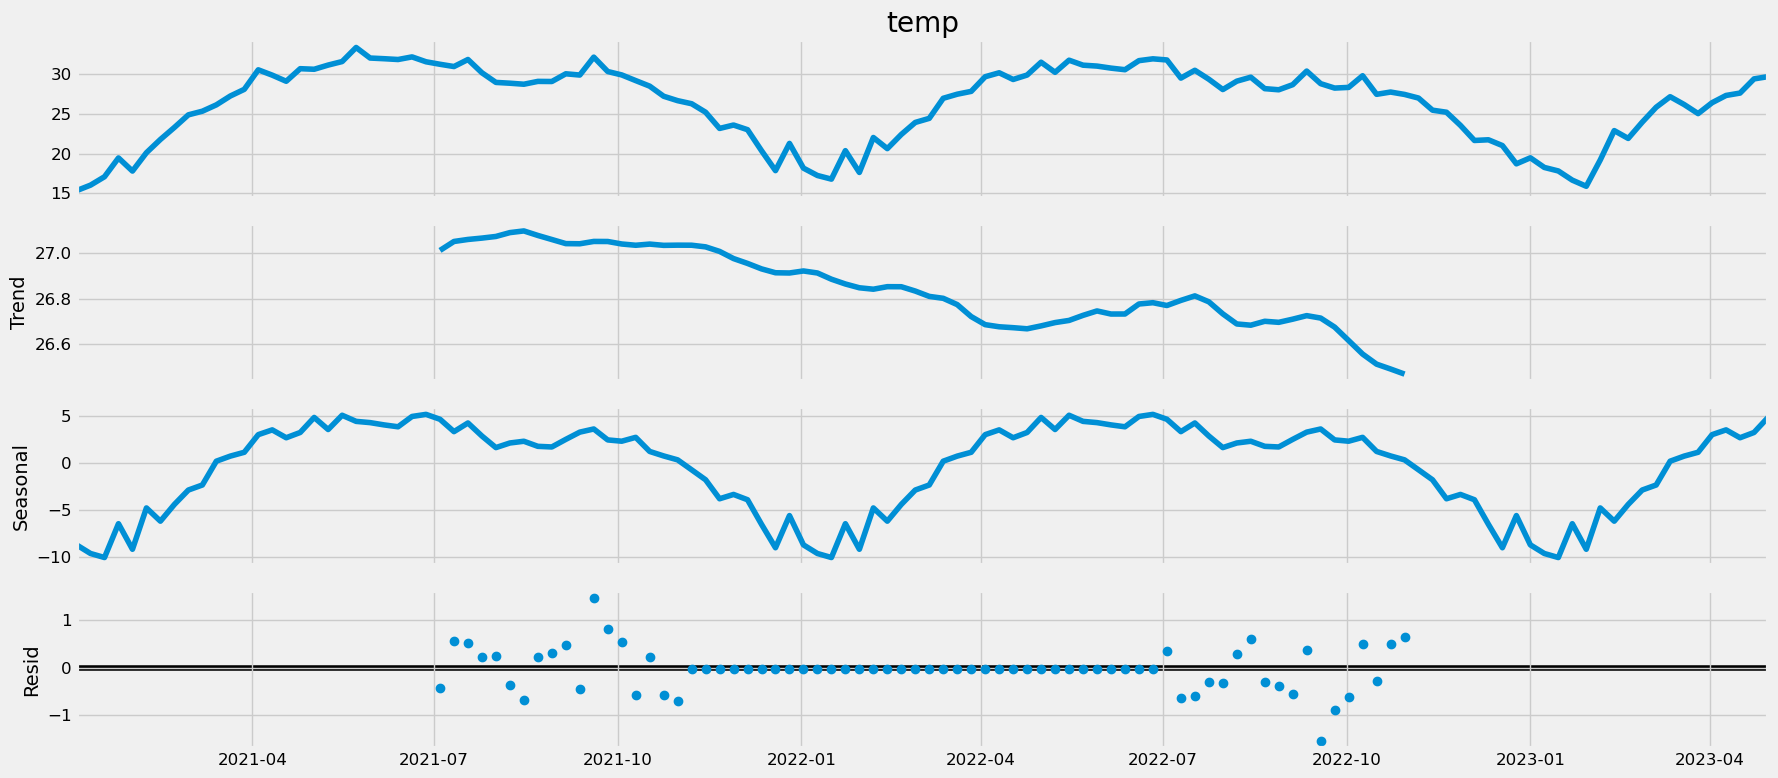

In [12]:
decomposition = sm.tsa.seasonal_decompose(week_data, model='additive')
rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()

The trend plot shows a gradual decrease over time, indicating a negative long-term trend in the data.

The seasonal plot exhibits repetitive patterns. The value is close to -10 during the winter season in Pakistan and the value is close to 5 during the summer season. This is pretty accurate as temperature is high during summer and low during winter.

In the resid graph, the dots away from the line indicate noise.

### Q3

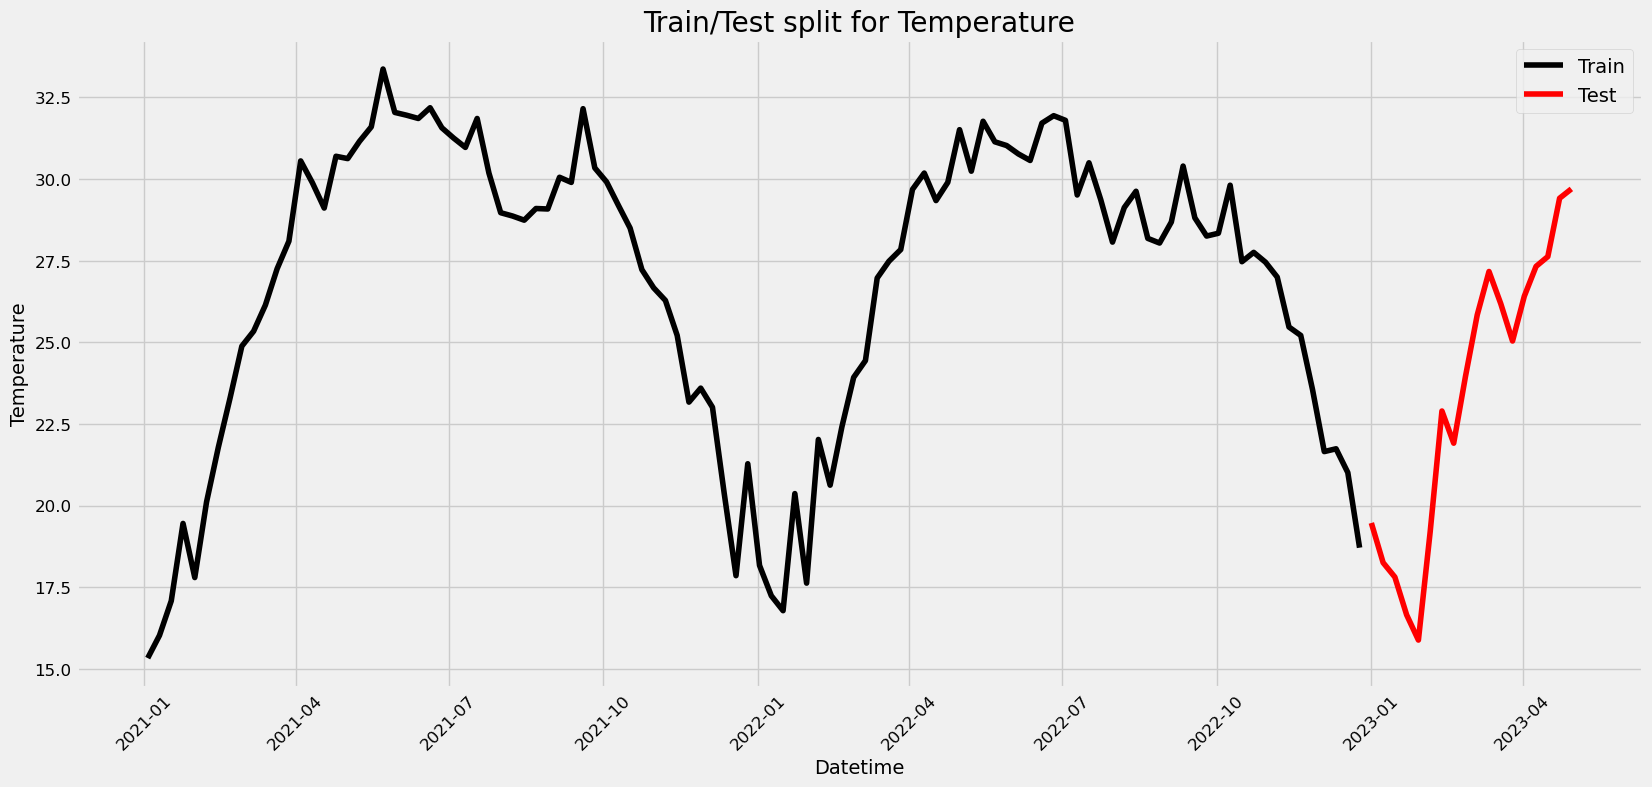

In [13]:
train = week_data[(week_data.index >= pd.to_datetime("2021-01-01", format='%Y-%m-%d')) & (week_data.index < pd.to_datetime("2023-01-01", format='%Y-%m-%d'))]
test = week_data[week_data.index >= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Datetime')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature")
plt.legend()
plt.show()

As we can see from the graph, the black line shows the training data (2021 - 2022) while the red line shows the testing data (2023).

### Q4

In [14]:
from statsmodels.tsa.arima.model import ARIMA

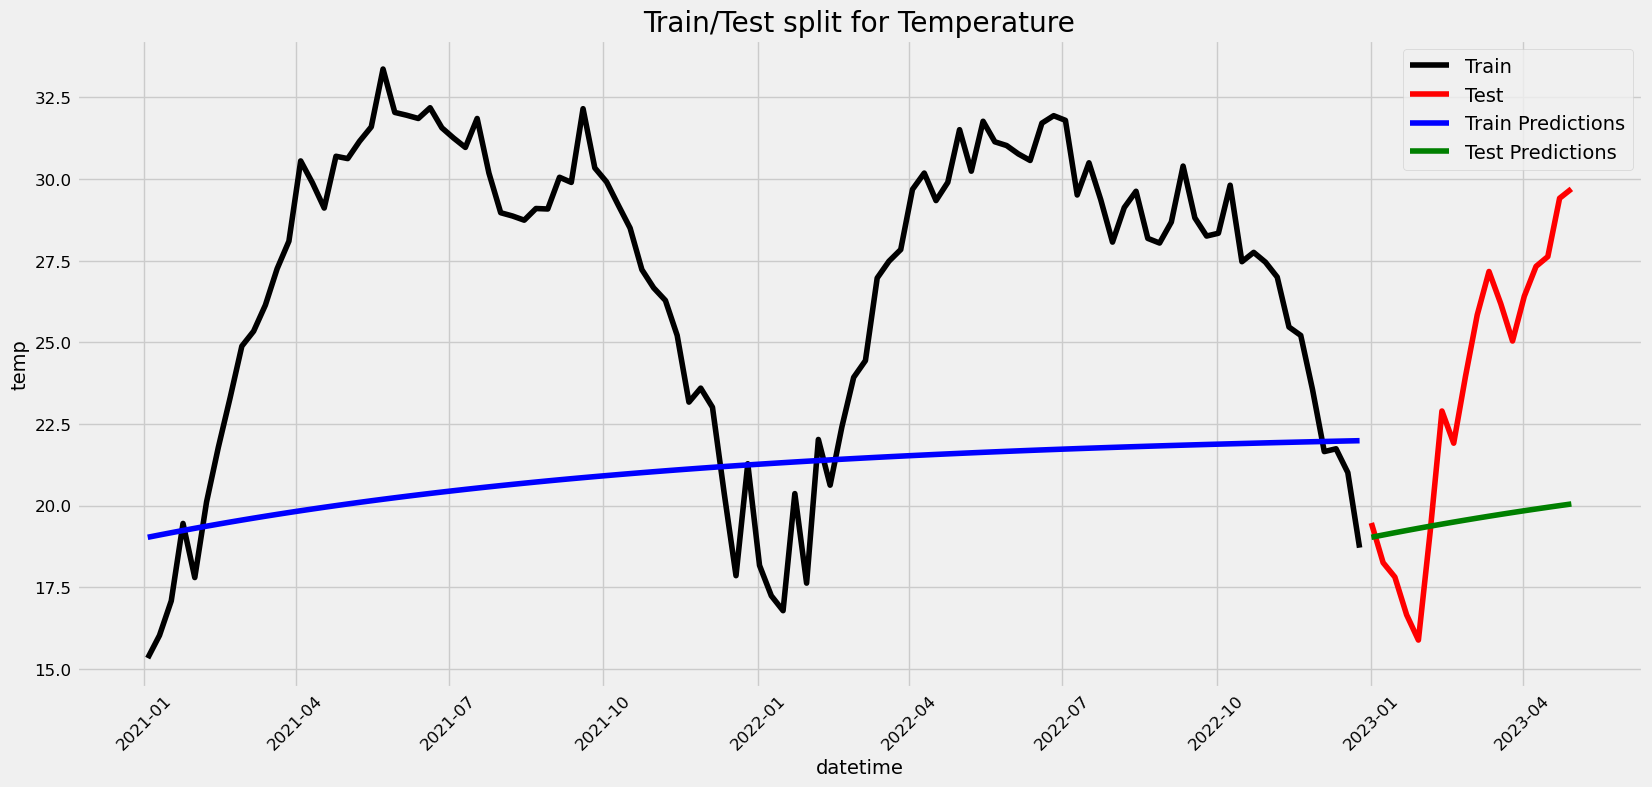

RMSE:  5.584076088881663


In [15]:
ARIMAmodel = ARIMA(train, order = (1, 0, 1))

ARIMAmodel = ARIMAmodel.fit()

# Train set prediction
y_pred_train = ARIMAmodel.get_forecast(len(train.index)) #only providing dates (train.index) from test as input for forecasting
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05) 
y_pred_df_train["Predictions"] = ARIMAmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])

# For training prediction plotting purposes
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"] 

# Test set prediction
y_pred = ARIMAmodel.get_forecast(len(test.index)) #only providing dates (test.index) from test as input for forecasting
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

# For test prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('temp')
plt.xlabel('datetime')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')
plt.plot(y_pred_out, color='green', label = 'Test Predictions')

plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

Both the training predictions and the testing predictions are very bad. It is because we used very simple, one coefficient kind of model which does not go very quick.

The RMSE value is 5.584

In [16]:
print(ARIMAmodel.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  104
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -184.529
Date:                Sat, 25 Nov 2023   AIC                            377.058
Time:                        14:20:48   BIC                            387.636
Sample:                    01-03-2021   HQIC                           381.343
                         - 12-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.3471      4.040      5.531      0.000      14.429      30.266
ar.L1          0.9786      0.025     39.421      0.000       0.930       1.027
ma.L1         -0.1002      0.090     -1.118      0.2

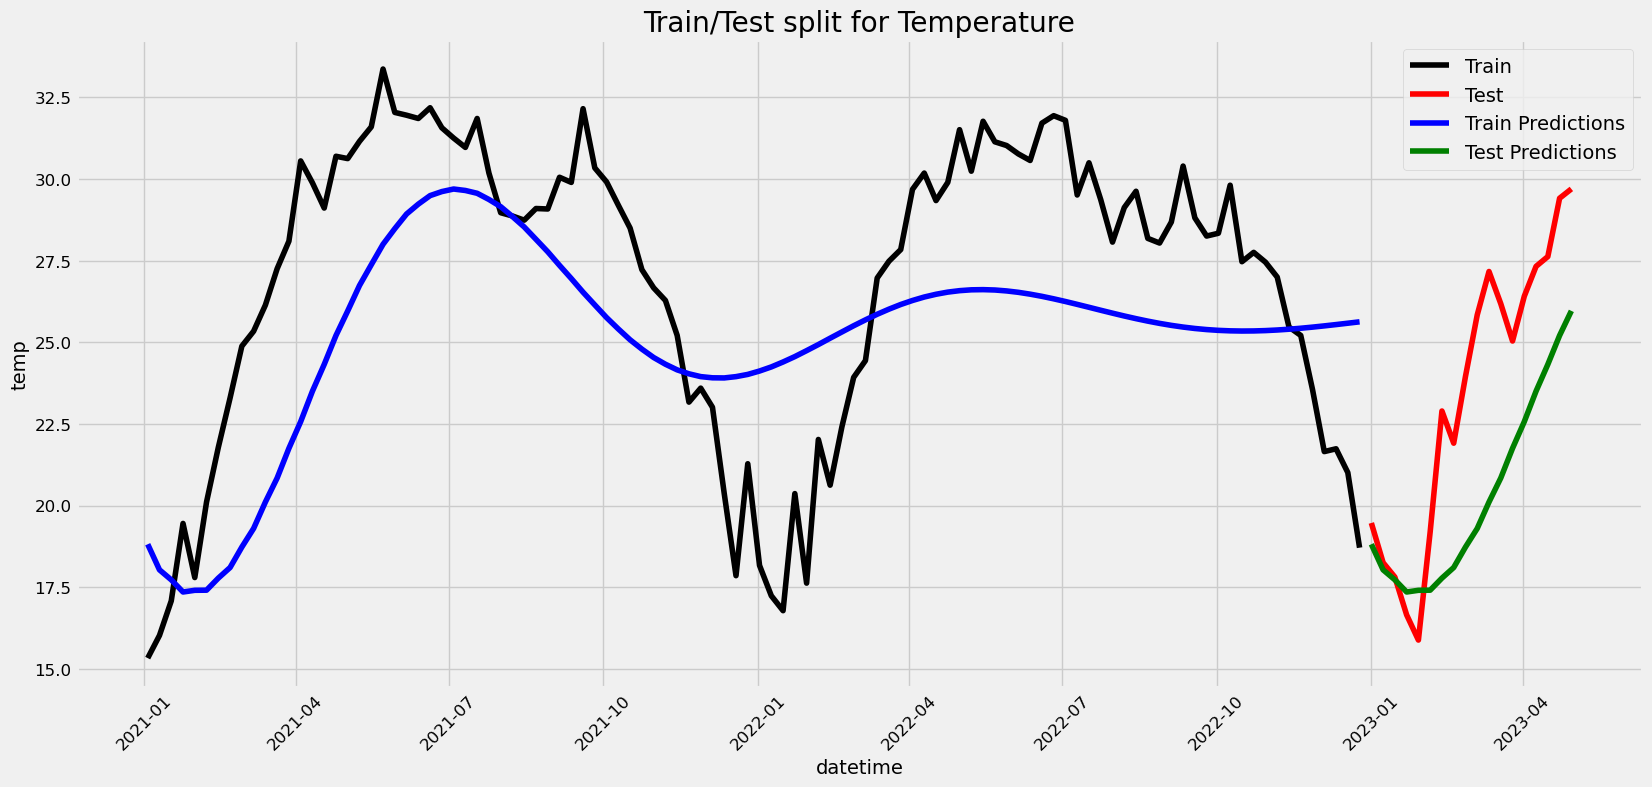

RMSE:  3.9313030183347606


In [17]:
ARIMAmodel = ARIMA(train, order = (3, 0, 3))

ARIMAmodel = ARIMAmodel.fit()

# Train set prediction
y_pred_train = ARIMAmodel.get_forecast(len(train.index)) #only providing dates (train.index) from test as input for forecasting
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05) 
y_pred_df_train["Predictions"] = ARIMAmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])

# For training prediction plotting purposes
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"] 

# Test set prediction
y_pred = ARIMAmodel.get_forecast(len(test.index)) #only providing dates (test.index) from test as input for forecasting
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

# For test prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('temp')
plt.xlabel('datetime')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')
plt.plot(y_pred_out, color='green', label = 'Test Predictions')

plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

We can see that the train predictions and test predictions have improved when we changed the coefficient to 3.

The RMSE value is 3.931 which is better than the previous value.

### Q5

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


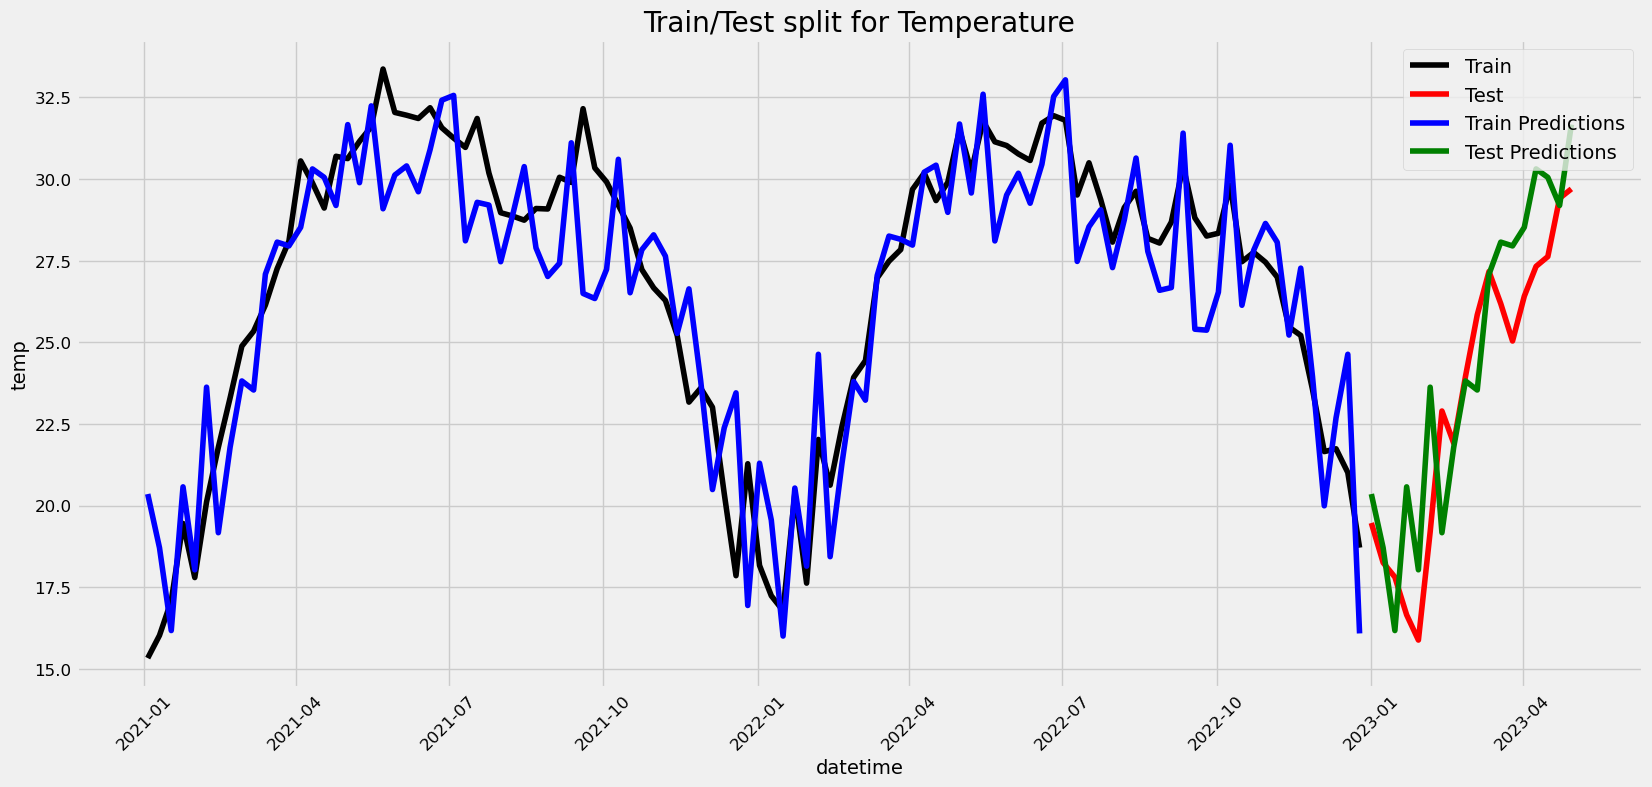

RMSE:  2.3300491652292132


In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMAXmodel = SARIMAX(train,order=(3, 0, 3),seasonal_order=(1, 1, 1, 52))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred_train = SARIMAXmodel.get_forecast(len(train.index))
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05) 
y_pred_df_train["Predictions"] = SARIMAXmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"] 

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('temp')
plt.xlabel('datetime')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')
plt.plot(y_pred_out, color='green', label = 'Test Predictions')
plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

We can see that the train and test predictions have improved as compared to ARIMA.

Using the same parameters: (3,0,3) in both ARIMA and SARIMAX, SARIMAX gave better predictions. The RMSE value of SARIMAX is 2.330 which is also better than ARIMA.

### Q6

In [49]:
p = d = q = range(0, 2)
P = Q = D = range(1, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [50]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 52)12 - AIC:975.881154723683
SARIMAX(0, 0, 0)x(0, 0, 1, 52)12 - AIC:485.8186289351568
SARIMAX(0, 0, 0)x(0, 1, 0, 52)12 - AIC:169.29047146057792
SARIMAX(0, 0, 0)x(0, 1, 1, 52)12 - AIC:4.0
SARIMAX(0, 0, 0)x(1, 0, 0, 52)12 - AIC:174.99214845878188
SARIMAX(0, 0, 0)x(1, 0, 1, 52)12 - AIC:168.5857516201465
SARIMAX(0, 0, 0)x(1, 1, 0, 52)12 - AIC:4.0
SARIMAX(0, 0, 0)x(1, 1, 1, 52)12 - AIC:6.0
SARIMAX(0, 0, 1)x(0, 0, 0, 52)12 - AIC:841.1847615260965
SARIMAX(0, 0, 1)x(0, 0, 1, 52)12 - AIC:414.8472562943157
SARIMAX(0, 0, 1)x(0, 1, 0, 52)12 - AIC:167.4848414370725
SARIMAX(0, 0, 1)x(0, 1, 1, 52)12 - AIC:6.0
SARIMAX(0, 0, 1)x(1, 0, 0, 52)12 - AIC:176.54367022146334


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(0, 0, 1)x(1, 0, 1, 52)12 - AIC:166.86725566539218
SARIMAX(0, 0, 1)x(1, 1, 0, 52)12 - AIC:6.0
SARIMAX(0, 0, 1)x(1, 1, 1, 52)12 - AIC:8.0
SARIMAX(0, 1, 0)x(0, 0, 0, 52)12 - AIC:364.73089345661924
SARIMAX(0, 1, 0)x(0, 0, 1, 52)12 - AIC:184.8583184365949
SARIMAX(0, 1, 0)x(0, 1, 0, 52)12 - AIC:193.02368172034699
SARIMAX(0, 1, 0)x(0, 1, 1, 52)12 - AIC:4.0
SARIMAX(0, 1, 0)x(1, 0, 0, 52)12 - AIC:182.3405573384717
SARIMAX(0, 1, 0)x(1, 0, 1, 52)12 - AIC:181.12527515549473
SARIMAX(0, 1, 0)x(1, 1, 0, 52)12 - AIC:4.0
SARIMAX(0, 1, 0)x(1, 1, 1, 52)12 - AIC:6.0
SARIMAX(0, 1, 1)x(0, 0, 0, 52)12 - AIC:361.8151418404942
SARIMAX(0, 1, 1)x(0, 0, 1, 52)12 - AIC:181.53409184436055
SARIMAX(0, 1, 1)x(0, 1, 0, 52)12 - AIC:167.94435389366078
SARIMAX(0, 1, 1)x(0, 1, 1, 52)12 - AIC:6.0
SARIMAX(0, 1, 1)x(1, 0, 0, 52)12 - AIC:165.58809334211486
SARIMAX(0, 1, 1)x(1, 0, 1, 52)12 - AIC:159.8745379604355
SARIMAX(0, 1, 1)x(1, 1, 0, 52)12 - AIC:6.0
SARIMAX(0, 1, 1)x(1, 1, 1, 52)12 - AIC:8.0
SARIMAX(1, 0, 0)x(0, 0

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(1, 0, 0)x(0, 0, 1, 52)12 - AIC:189.84266259292082
SARIMAX(1, 0, 0)x(0, 1, 0, 52)12 - AIC:170.1342870413973
SARIMAX(1, 0, 0)x(0, 1, 1, 52)12 - AIC:6.0
SARIMAX(1, 0, 0)x(1, 0, 0, 52)12 - AIC:168.11895585152456
SARIMAX(1, 0, 0)x(1, 0, 1, 52)12 - AIC:186.1850856452077
SARIMAX(1, 0, 0)x(1, 1, 0, 52)12 - AIC:6.0
SARIMAX(1, 0, 0)x(1, 1, 1, 52)12 - AIC:8.0
SARIMAX(1, 0, 1)x(0, 0, 0, 52)12 - AIC:366.90608479246987
SARIMAX(1, 0, 1)x(0, 0, 1, 52)12 - AIC:186.23543527782482
SARIMAX(1, 0, 1)x(0, 1, 0, 52)12 - AIC:168.19911526668483
SARIMAX(1, 0, 1)x(0, 1, 1, 52)12 - AIC:8.0
SARIMAX(1, 0, 1)x(1, 0, 0, 52)12 - AIC:169.03868821046325
SARIMAX(1, 0, 1)x(1, 0, 1, 52)12 - AIC:165.29352189078048
SARIMAX(1, 0, 1)x(1, 1, 0, 52)12 - AIC:8.0
SARIMAX(1, 0, 1)x(1, 1, 1, 52)12 - AIC:10.0
SARIMAX(1, 1, 0)x(0, 0, 0, 52)12 - AIC:364.2060077596135
SARIMAX(1, 1, 0)x(0, 0, 1, 52)12 - AIC:182.64342285199126
SARIMAX(1, 1, 0)x(0, 1, 0, 52)12 - AIC:184.54528820603295
SARIMAX(1, 1, 0)x(0, 1, 1, 52)12 - AIC:6.0
SARIM

The loswest AIC is 4.0. One of the optimal parameters with this AIC are: (0,0,0) (1,1,0,52)

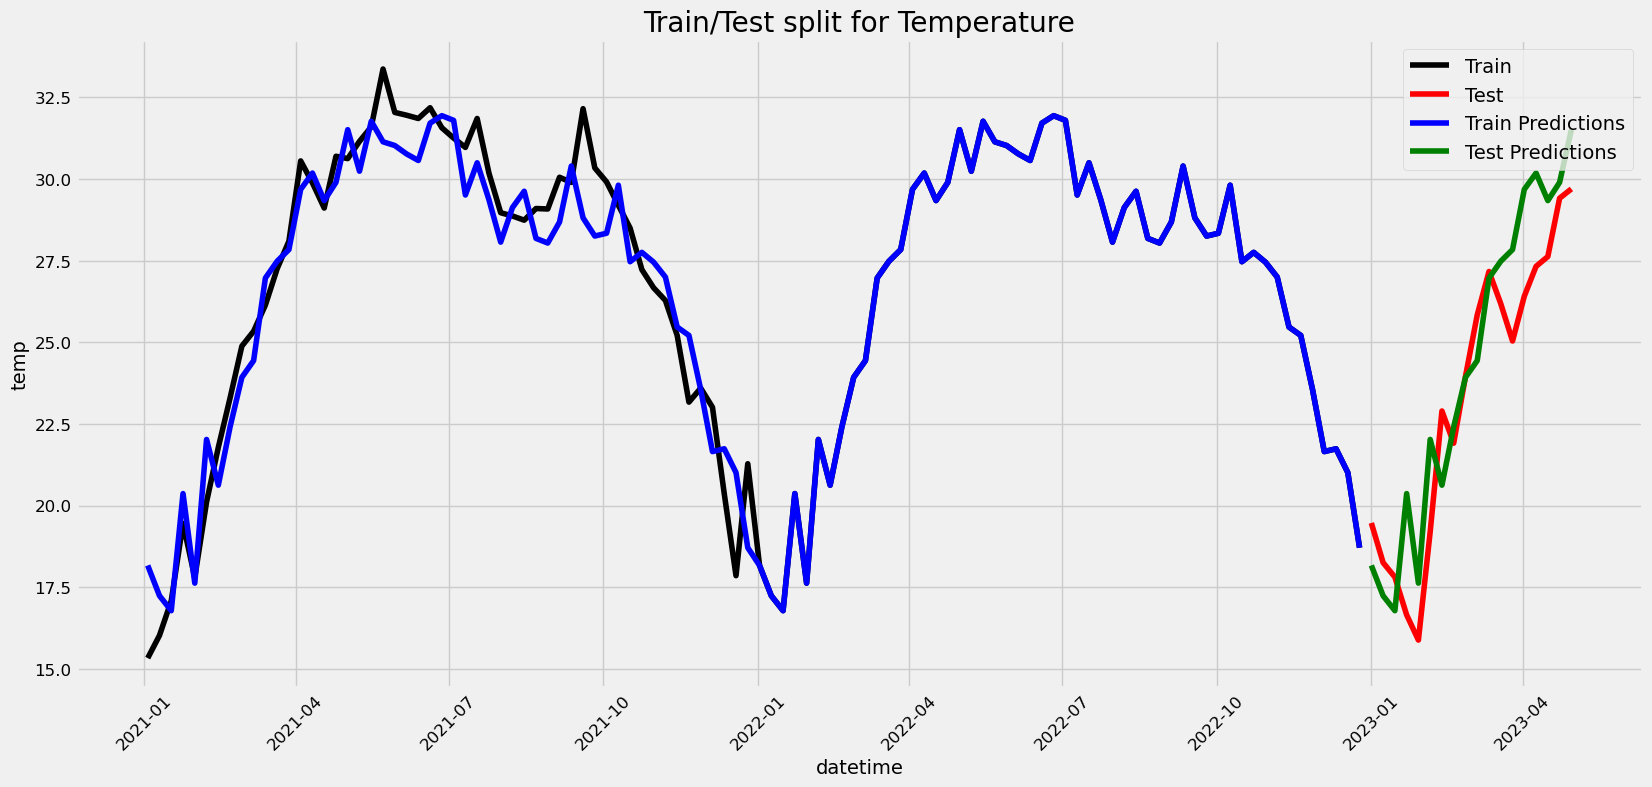

RMSE:  1.9844221971500138


In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMAXmodel = SARIMAX(train,order=(0, 0, 0),seasonal_order=(1, 1, 0, 52))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred_train = SARIMAXmodel.get_forecast(len(train.index))
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05) 
y_pred_df_train["Predictions"] = SARIMAXmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"] 

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('temp')
plt.xlabel('datetime')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')
plt.plot(y_pred_out, color='green', label = 'Test Predictions')
plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

As we can see from the graph the prediction is much accurate now and closer to real values. We chose one of the optimal parameters: order=(0, 0, 0),seasonal_order=(1, 1, 0,52). The RMSE value has also decreased even more as it is now 1.984.

SARIMAX is better than ARIMA as in both cases: where we used the same parameters as ARIMA, and where we used the optimal parameters of SARIMAX, the RMSE value of SARIMAX was better than ARIMA. SARIMAX gave better predictions.

### Q7

#### Machine Learning 1

In [26]:
import numpy as np
 
# extract the seasonality data
months = [x.month for x in train.index]
years = [x.year for x in train.index]
day = [x.day for x in train.index]
 
# convert into one matrix
X = np.array([day, months, years]).T
Y = train.values

# extract the day, month and year data
tmonths = [x.month for x in test.index]
tyears = [x.year for x in test.index]
tday = [x.day for x in test.index]
 
# convert into one matrix
testX = np.array([tday, tmonths, tyears]).T
testY = test.values

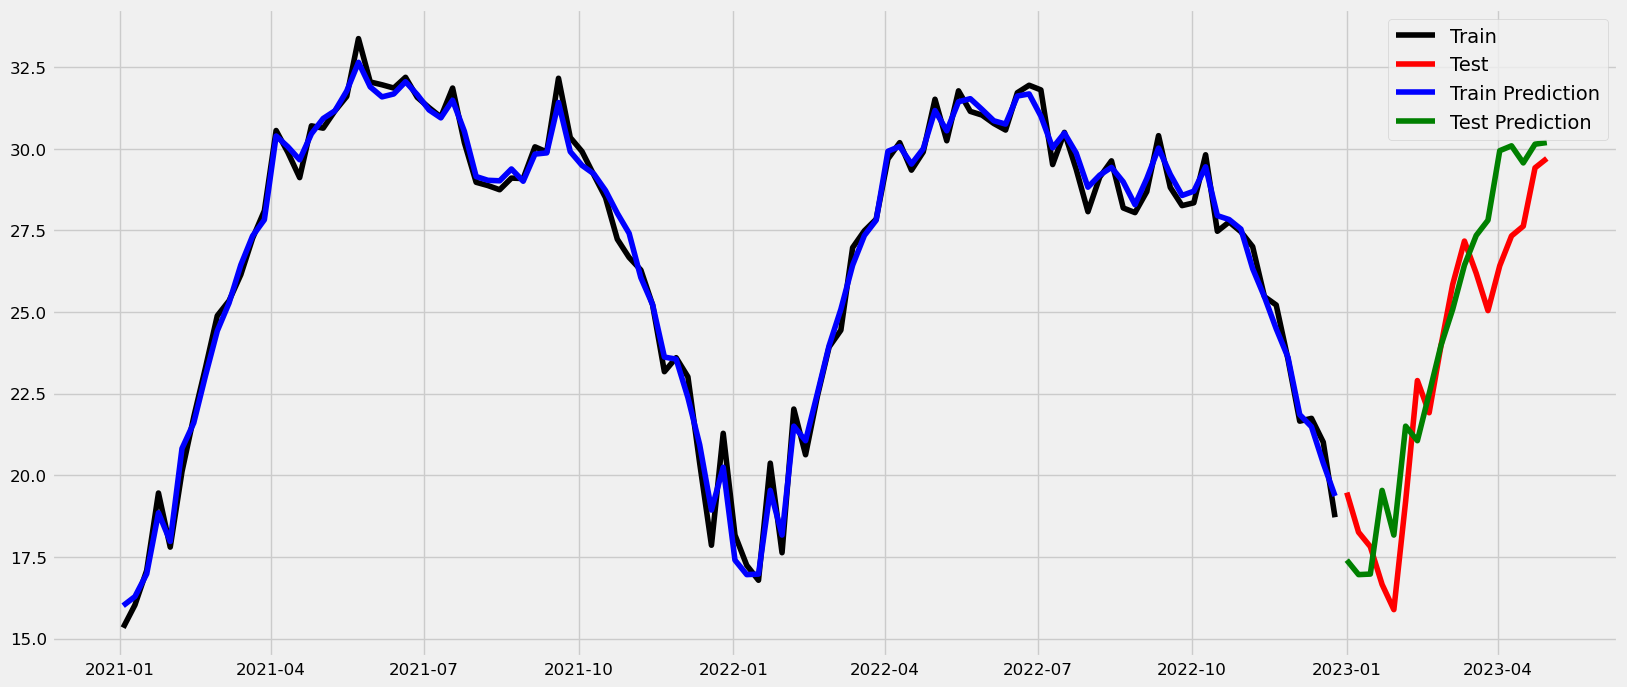

RMSE:  1.8842120834340963


In [29]:
from sklearn.ensemble import RandomForestRegressor
 
# fit the model
rfmodel = RandomForestRegressor(random_state=10)
rfmodel.fit(X,Y)
 
preds_train = rfmodel.predict(X)
preds = rfmodel.predict(testX)
 
# plot what has been learned
plt.plot(train.index, train.values,color="black", label='Train')
plt.plot(test.index, test.values,color="red", label='Test')
plt.plot(train.index, preds_train, color="blue",label='Train Prediction')
plt.plot(test.index, preds, color="green",label='Test Prediction')

plt.legend()
plt.show()
rf_rmse = np.sqrt(mean_squared_error(test.values, preds))
print("RMSE: ",rf_rmse)

Using the Random Forest model, the RMSE decreased even more and the predictions got better than the optimal parameters of SARIMAX.

#### Machine Learning 2

In [31]:
from sklearn.linear_model import LinearRegression

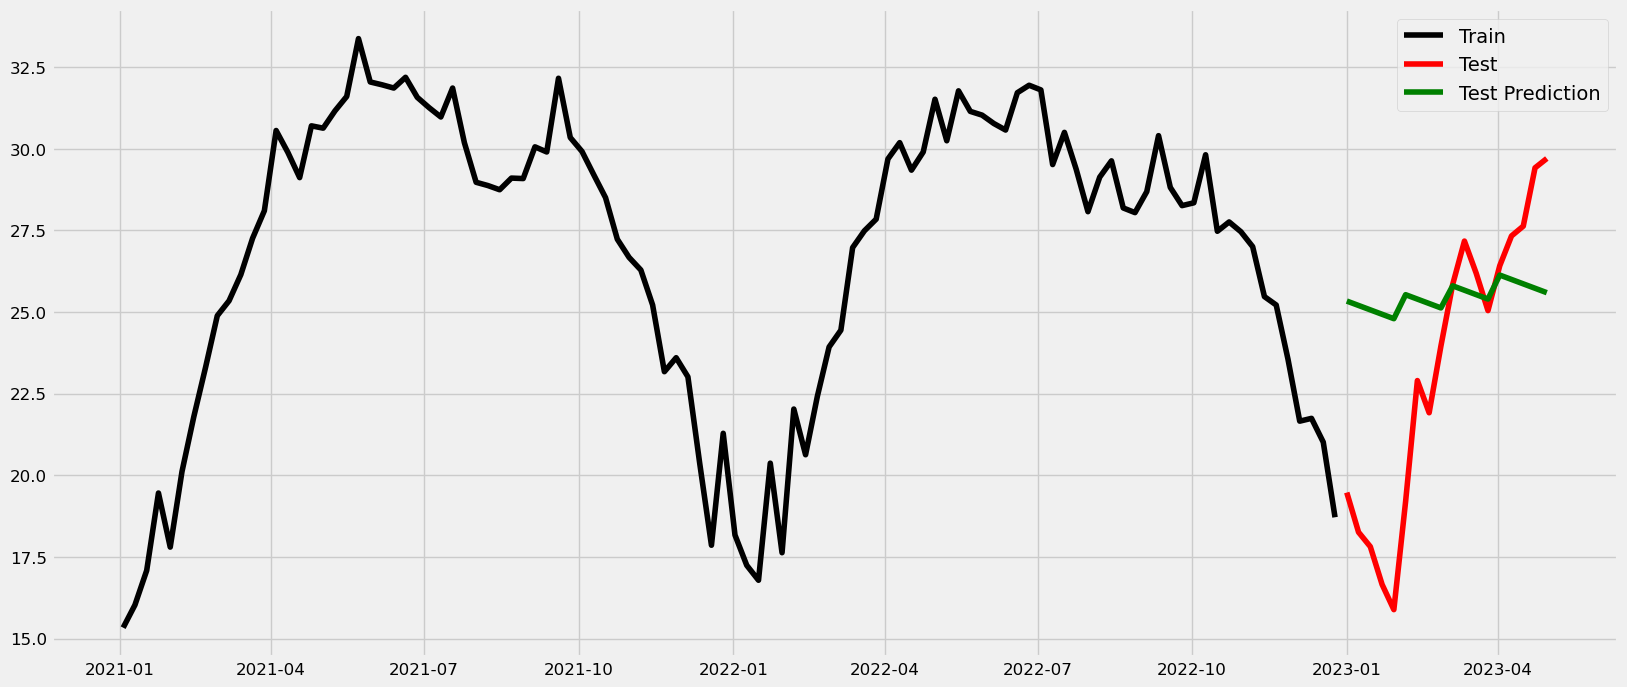

RMSE:  4.595195832128814


In [38]:
rfmodel = LinearRegression()
rfmodel.fit(X, Y)

preds = rfmodel.predict(testX)
plt.plot(train.index, train.values, color="black", label='Train')
plt.plot(test.index, test.values, color="red", label='Test')

# only predicting test values as dimensions of x and y are different
plt.plot(test.index, preds, color="green", label='Test Prediction')

plt.legend()
plt.show()
rf_rmse = np.sqrt(mean_squared_error(test.values, preds))
print("RMSE: ", rf_rmse)

Using the Linear Regression, the test prediction is not good. The RMSE value is also not good as compared to the other models.

### Q8

RMSE values:
- ARIMA (1, 0, 1): 5.584
- ARIMA with better parameters (3, 0, 3): 3.931
- SARIMAX with beter parameters (3, 0, 3): 2.330
- SARIMAX with optimal parameters (1, 1, 0): 1.984
- ML Random Forest: 1.884
- ML Linear Regression: 4.595

The best RMSE value is of ML Random Forest technique. Although SARIMAX with optimal parameters is much close to the RMSE value of Random Forest as well so I would say that these two are the better ones compared to the rest.

### Q9

In [40]:
futureX = pd.date_range(start='01/04/2023', end='31/12/2023', freq = 'W')

In [41]:
futureX

DatetimeIndex(['2023-01-08', '2023-01-15', '2023-01-22', '2023-01-29',
               '2023-02-05', '2023-02-12', '2023-02-19', '2023-02-26',
               '2023-03-05', '2023-03-12', '2023-03-19', '2023-03-26',
               '2023-04-02', '2023-04-09', '2023-04-16', '2023-04-23',
               '2023-04-30', '2023-05-07', '2023-05-14', '2023-05-21',
               '2023-05-28', '2023-06-04', '2023-06-11', '2023-06-18',
               '2023-06-25', '2023-07-02', '2023-07-09', '2023-07-16',
               '2023-07-23', '2023-07-30', '2023-08-06', '2023-08-13',
               '2023-08-20', '2023-08-27', '2023-09-03', '2023-09-10',
               '2023-09-17', '2023-09-24', '2023-10-01', '2023-10-08',
               '2023-10-15', '2023-10-22', '2023-10-29', '2023-11-05',
               '2023-11-12', '2023-11-19', '2023-11-26', '2023-12-03',
               '2023-12-10', '2023-12-17', '2023-12-24', '2023-12-31'],
              dtype='datetime64[ns]', freq='W-SUN')

In [42]:
t_months = [x.month for x in futureX]
t_years = [x.year for x in futureX]
t_day = [x.day for x in futureX]

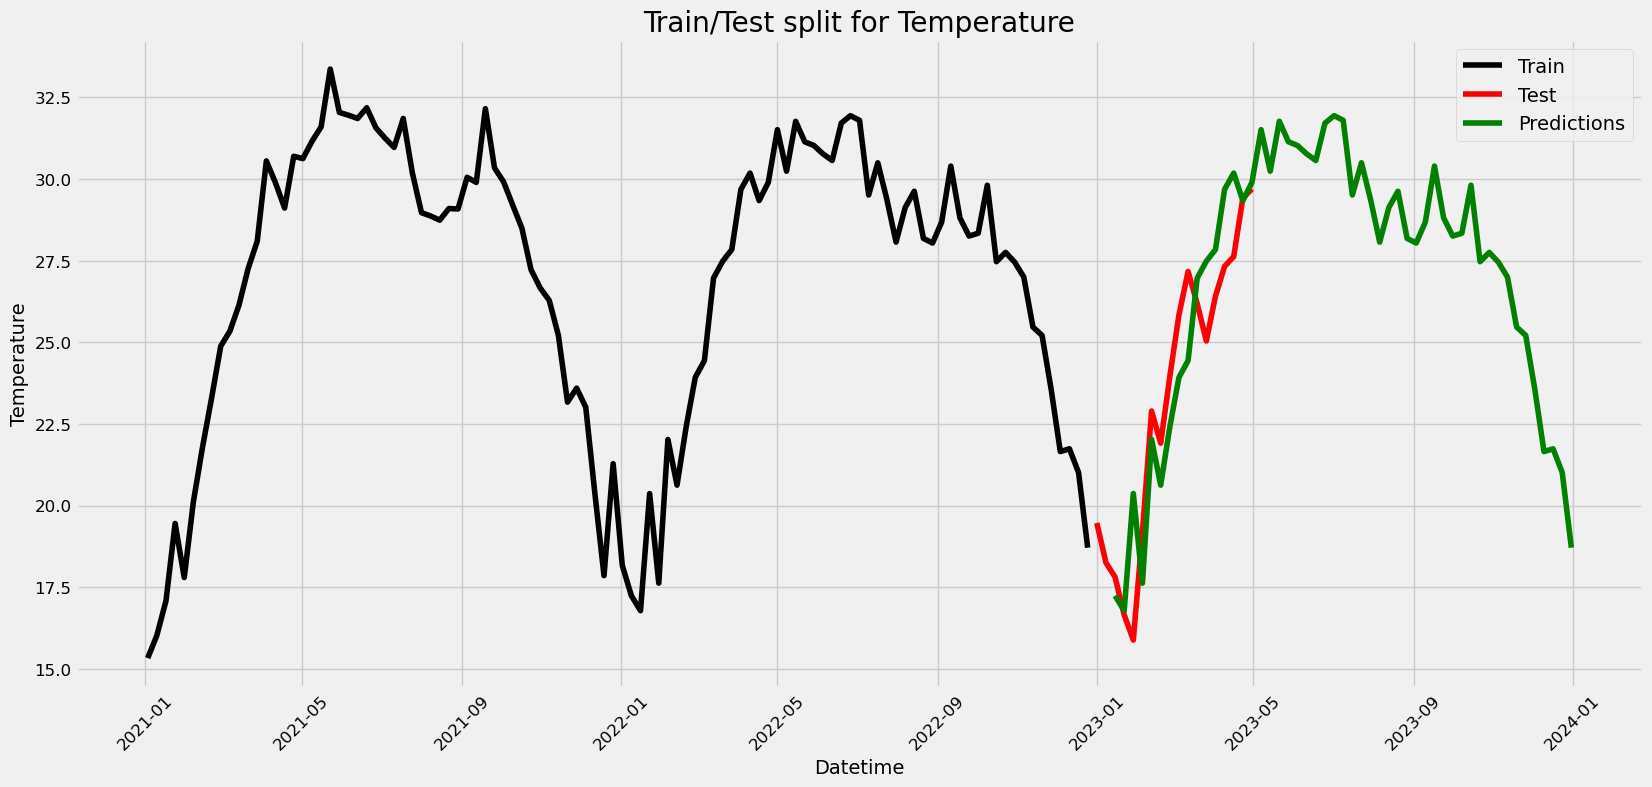

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMAXmodel = SARIMAX(train, order=(0, 0, 0), seasonal_order=(1, 1, 0, 52))
SARIMAXmodel = SARIMAXmodel.fit(disp=0)

y_pred = SARIMAXmodel.get_forecast(len(futureX))
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df["Predictions"] = SARIMAXmodel.predict(start=futureX[0], end=futureX[-1])
y_pred_df.index = futureX
y_pred_out = y_pred_df["Predictions"]

plt.plot(train, color="black", label='Train')
plt.plot(test, color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Datetime')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature")

plt.plot(y_pred_out, color='green', label='Predictions')
plt.legend()
plt.show()

### Q10

#### Random Forest 

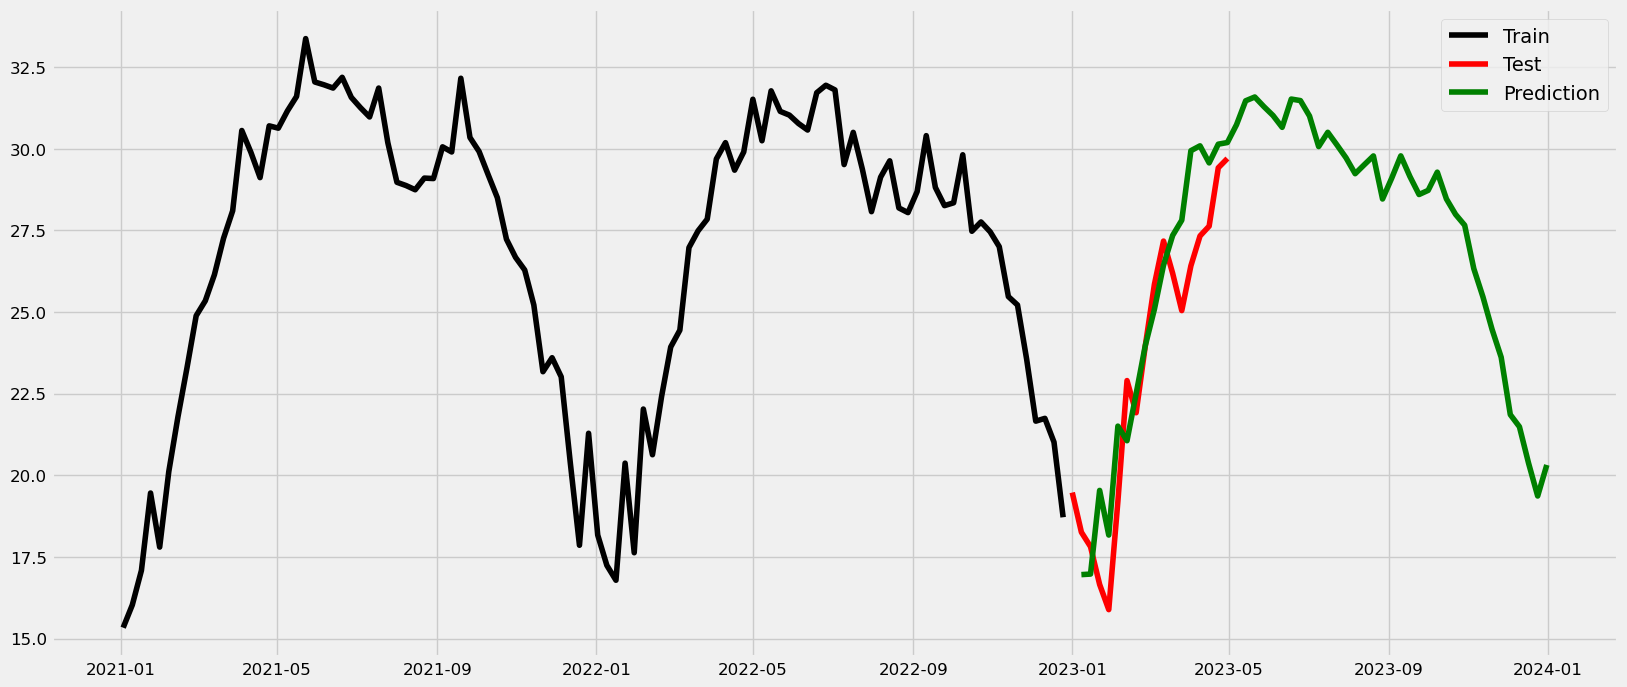

In [47]:
# convert into one matrix
testX = np.array([t_day, t_months, t_years]).T

# fit the model
rfmodel = RandomForestRegressor(random_state=10)
rfmodel.fit(X, Y)

preds = rfmodel.predict(testX)

plt.plot(train.index, train.values, color="black", label='Train')
plt.plot(test.index, test.values, color="red", label='Test')
plt.plot(futureX, preds, color="green", label='Prediction')
plt.legend()
plt.show()

### Q11

We visualized both SARIMA in Q9 and Random Forest in Q10. If we notice the the prediction in SARIMAX, it is nearly the same for 2023 as it was for 2022. While the Random Forest kind of gives a prediction based on both 2021 and 2022. There is not much difference in the real values of test and the predictions if we compare both graphs, both of the predictions are not far away from the real values.